# Pythonによる定期処理(10ms)精度確認スクリプト
元ネタ↓<br>
https://gist.github.com/tilt-silvie/577cb78cf27886b6bcf792c9868eb4e6 <br>
少しソースコード改変しています

In [2]:
import time
import numpy as np
from threading import Timer
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display as IPython_display
from sklearn.preprocessing import MinMaxScaler

class RepeatedTimer(Timer):
  def __init__(self, interval, function, args=[], kwargs={}):
    Timer.__init__(self, interval, self.run, args, kwargs)
    self.thread = None
    self.function = function

  def run(self):
    self.thread = Timer(self.interval, self.run)
    self.thread.start()
    self.function(*self.args, **self.kwargs)

  def cancel(self):
    if self.thread is not None:
      self.thread.cancel()
      self.thread.join()
      del self.thread

class Log:
    def __init__(self):
        self.logs = []

    def add(self, data):
        self.logs.append(data)

    def get(self):
        return self.logs

def func(logger):
    logger.add(time.perf_counter())

In [3]:
def measurement_python_timer(timer_interval, measurement_duration):
    log = Log()

    t = RepeatedTimer(timer_interval, func, [log])
    t.start()
    time.sleep(measurement_duration)
    t.cancel()

    diff = np.diff(log.get())
    df = pd.DataFrame(data=diff, columns=['time'])
    return df

In [4]:
def display_result(df):
    # describe
    IPython_display(df.describe())
    
    # boxplot
    fig, ax = plt.subplots(figsize=(10, 7.5))
    ax.boxplot(df['time'], whis=[4.55, 95.45])
    ax.set_xticklabels(['time'])
    plt.show()

In [5]:
# 10msでテスト
df10 = measurement_python_timer(0.01, 5.00)

In [6]:
# 100msでテスト
df100 = measurement_python_timer(0.1, 5.00)

,time
count,424.000000
mean,0.011785
std,0.000970
min,0.010148
25%,0.010864
50%,0.011964
75%,0.012775
max,0.012977


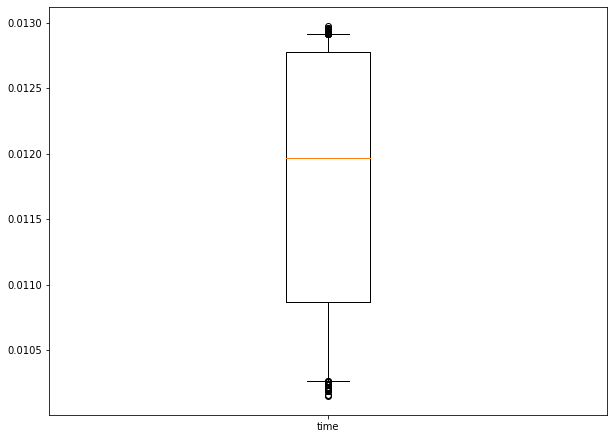

In [7]:
display_result(df10)

,time
count,48.000000
mean,0.103219
std,0.001722
min,0.100250
25%,0.101669
50%,0.103646
75%,0.104719
max,0.105488


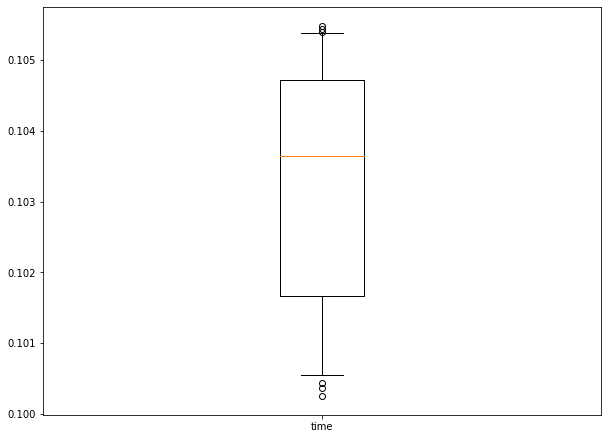

In [8]:
display_result(df100)

In [9]:
mmscaler = MinMaxScaler()
mmscaler.fit(df10)
df10["time_mms"] = mmscaler.transform(df10)

mmscaler = MinMaxScaler()
mmscaler.fit(df100)
df100["time_mms"] = mmscaler.transform(df100)

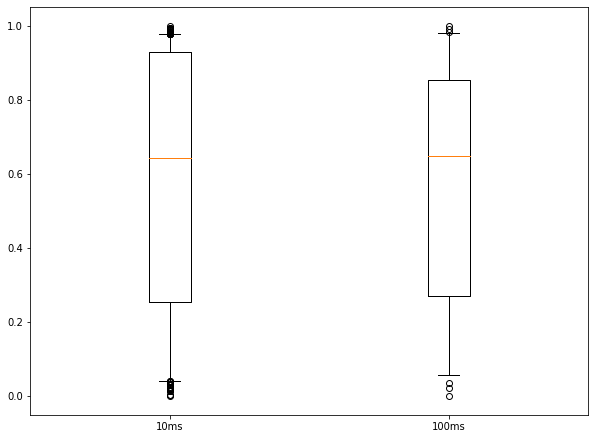

In [10]:
# boxplot
fig, ax = plt.subplots(figsize=(10, 7.5))
ax.boxplot((df10['time_mms'], df100['time_mms']), whis=[4.55, 95.45])
ax.set_xticklabels(['10ms','100ms'])
plt.show()

In [11]:
df10.head()

,time,time_mms
0,0.011075,0.327565
1,0.010951,0.283734
2,0.011555,0.497259
3,0.010279,0.046509
4,0.012899,0.972199
